Notebook réalisé par [Pierre-Alexandre Aranega](mailto:pierre-alexandre.aranega@ensae.fr) et [Charles Cros](mailto:charles.cros@ensae.fr) dans le cadre du projet **Python pour l'économiste** (ENSAE 2A - 2019-2020).

## Introduction

Le 3 décembre 2019, l'OCDE a publié les résultats de l'enquête PISA (*Programme for International Student Assessment*) menée en 2018 dans 79 pays, sur des élèves de 15 ans, et répétée tous les trois ans depuis l'an 2000. Ces résultats sont très commentés et sont considérés comme un indicateur pertinent de l'évolution du niveau scolaire des élèves, de manière absolue et de manière relative (en comparaison avec les pays voisins). Quelques articles sur la question :

* [Nouveau classement PISA : l'école française, cet élève moyen qui ne progresse pas](http://www.leparisien.fr/societe/nouveau-classement-pisa-l-ecole-francaise-cet-eleve-moyen-qui-ne-progresse-pas-03-12-2019-8208645.php) (Le Parisien, 3 déc. 2019)
* [Enquête PISA : dix résultats pour situer les élèves français](https://www.lesechos.fr/politique-societe/societe/enquete-pisa-dix-resultats-pour-situer-les-eleves-francais-1153200) (Les Échos, 3 déc. 2019)
* [La France aura-t-elle un jour son choc Pisa ?](https://www.lepoint.fr/education/systeme-educatif-la-france-aura-t-elle-un-jour-son-choc-pisa-03-12-2019-2351038_3584.php) (Le Point, 3 déc. 2019)
* [Enquête PISA 2018 : stabilité des résultats des élèves français de 15 ans](https://www.education.gouv.fr/cid147361/enquete-pisa-2018-stabilite-des-resultats-des-eleves-francais-de-15-ans.html) (Communiqué de presse, Jean-Michel Blanquer, 3 déc. 2019)
* [PISA 2018 : stabilité des résultats en compréhension de l'écrit](https://www.education.gouv.fr/cid54176/pisa-2018-stabilite-des-resultats-en-comprehension-de-l-ecrit.html) (Note d'information, Ministère de l'Éducation, 3 déc. 2019)

Suivant les articles ou les publications officielles, il est difficile de savoir s'il faut ou non se réjouir de ces résultats. Les commentaires ne sont jamais neutres : certains s'inquiètent d'une nouvelle baisse des résultats français ; d'autres relativisent, observent que cette baisse est tout de même moins forte que la précédente, et que la France reste au-dessus de la moyenne des pays de l'OCDE...

L'objectif de ce projet est de :
* Décrire les **résultats de l'édition 2018** de cette enquête, en portant une attention particulière au cas de la France.
* Décrire l'**évolution des résultats** depuis 2000,
* Explorer les **corrélations entre les variables**, et **avec d'autres variables**, notamment macroéconomiques.

Pour information, toutes les publications de l'OCDE sont disponibles [à cette adresse](https://www.oecd.org/pisa/publications/). L'enquête PISA couvre de très nombreux sujets, divers et passionnants, qui ne se limitent pas à la seule question de la performance. Soucieux de rester concis, on ne pourra évidemment pas tous les aborder ici.

## Table des matières

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import numpy as np
import pandas as pd
import urllib
import bs4
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.cluster import KMeans

## I. Import de données par scrapping

### A. Données PISA (source : Wikipedia)
Les données sont issues de la page Wikipedia [Programme for International Student Assessment](https://en.wikipedia.org/wiki/Programme_for_International_Student_Assessment).

In [3]:
url_wikipedia = "https://en.wikipedia.org/wiki/Programme_for_International_Student_Assessment"
request_text_PISA = urllib.request.urlopen(url_wikipedia).read()
page_PISA = bs4.BeautifulSoup(request_text_PISA, "lxml")

#### 1. Année 2018 (résultats publiés en décembre 2019)
Cette section se concentre sur le paragraphe [PISA 2018 ranking summary](https://en.wikipedia.org/wiki/Programme_for_International_Student_Assessment#PISA_2018_ranking_summary) qui donne les résultats de l'année 2018 dans un format particulier.

On aurait aimé disposer d'un id, d'une classe ou d'un titre permettant de cibler facilement le bon tableau. Faute de mieux, on se résout à utiliser une spécificité qui est la largeur de table, fixée à 240px pour les sous-tables qui nous intéressent ici.

In [4]:
# On se concentre sur les tables ayant la particularité de faire 240px de largeur...
tables_2018 = page_PISA.findAll("table", width="240")
tables_2018 = pd.read_html(str(tables_2018))

# On définit les headers manuellement afin d'harmoniser avec les intitulés de la partie suivante.
liste_matieres = ["Maths", "Science", "Reading"] 

# On fusionne ces tables dans un dataframe
PISA_2018 = pd.DataFrame()
for id_table in range(0,3):
    table = tables_2018[id_table].iloc[:,1:3]
    table.columns = ["Country", "Score"]
    table["Year"] = 2018
    table["Subject"] = liste_matieres[id_table]
    
    PISA_2018 = pd.concat([PISA_2018,table])
    
# Les résultats de la France en 2018
PISA_2018[PISA_2018["Country"]=="France"] 

Country  Score  Year  Subject
24  France    495  2018    Maths
23  France    493  2018  Science
22  France    493  2018  Reading

#### 2. Années 2000, 2003, 2006, 2009, 2012, 2015

Cette section se concentre sur le paragraphe [Rankings comparison 2003 - 2015](https://en.wikipedia.org/wiki/Programme_for_International_Student_Assessment#Rankings_comparison_2003_-_2015) qui regroupe les résultats des années précédentes.

De même que ci-dessus, nous n'avons pas d'id unique pour se référer aux tableaux qui nous intéressent. On choisit de ne garder que les tables ayant au moins 9 colonnes, ce qui permet de filtrer les trois tableaux qui nous préoccupent de manière un peu brutale, mais rapide.

In [5]:
all_tables = page_PISA.findAll("table")
all_tables = pd.read_html(str(all_tables), header=[0,1], na_values = ["—", "‡"])

# On ne s'intéresse qu'aux trois tables ayant + de 9 colonnes.

PISA = PISA_2018
for table in all_tables:
    if len(table.columns) > 8:
        subject = table.columns[0][0]
        table.columns = table.columns.droplevel(0)
        # On supprime toutes les colonnes de "rang" qui nous sont inutiles.
        for column in table.columns:
            if table[column][0] == "Rank":
                table = table.drop(columns=column)
        # On supprime les 2 premières lignes : "moyenne OCDE" et sous-titre "Score" qui nous sont inutiles.
        table = table.drop([0,1])
        # On dé-pivote les années.
        table = table.melt(id_vars="Country",var_name="Year",value_name="Score")
        # On ajoute la matière en colonne.
        table["Subject"] = subject
        # On fusionne avec le tableau complet, qui avait commencé à être créé pour l'année 2018.
        PISA = pd.concat([PISA,table], sort=True)      

PISA[PISA["Country"]=="France"].head()

Country Score  Subject  Year
24  France   495    Maths  2018
23  France   493  Science  2018
22  France   493  Reading  2018
22  France   493    Maths  2015
95  France   495    Maths  2012

#### 3. Nettoyage de la base de données produite

In [6]:
# Réinitialisation de l'index du dataframe, suite aux diverses concaténations / suppressions.
PISA = PISA.reset_index(drop=True)

# Suppression des scores N/A
PISA = PISA[pd.notnull(PISA["Score"])]

# Conversion de certains formats puis tri.
PISA["Year"]=PISA["Year"].astype(int)
PISA["Score"]=PISA["Score"].astype(int)
PISA = PISA.sort_values(by=["Year", "Subject", "Score"], ascending=False)

### B. Données complémentaires
On commence avant tout par régler quelques cas particuliers qui pourraient poser problème lors des jointures à venir.

In [7]:
# On ignore le cas particulier de Buenos Aires, traitée séparément du reste de l'Argentine.
PISA = PISA[PISA["Country"]!="Argentina CABA[b]"]

# On harmonise le nom de certains pays qui varient selon les bases.
PISA.loc[PISA["Country"].str.contains("China"), "Country"] = "China"
PISA["Country"] = PISA["Country"].replace("Hong Kong, China", "Hong Kong")
PISA["Country"] = PISA["Country"].replace("Czech Republic", "Czechia")
PISA["Country"] = PISA["Country"].replace(["South Korea", "Korea"], "Korea, South")

#### 1. Pays membres de l'OCDE (source : Wikipedia)

On souhaite disposer, dans la suite de ce devoir, de la [liste des pays membres de l'OCDE](https://en.wikipedia.org/wiki/OECD#Current_members). Ils constitueront notre pool de comparaison au fil du temps.

In [8]:
url_wikipedia_OECD = "https://en.wikipedia.org/wiki/OECD"
request_text_OECD = urllib.request.urlopen(url_wikipedia_OECD).read()
page_OECD = bs4.BeautifulSoup(request_text_OECD, "lxml")

In [9]:
OECD_countries = page_OECD.findAll("table", class_="wikitable sortable")
OECD_countries = pd.read_html(str(OECD_countries), header=0)[0]["Country"]
print("Les", len(OECD_countries), "pays membres de l'OCDE sont :", OECD_countries.str.cat(sep=", "))

Les 36 pays membres de l'OCDE sont : Australia, Austria, Belgium, Canada, Chile, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Japan, South Korea, Latvia, Lithuania, Luxembourg, Mexico, Netherlands, New Zealand, Norway, Poland, Portugal, Slovakia, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States


In [10]:
# Ajoutons cette information à la base principale
PISA["is_OECD"] = PISA.apply(lambda row : (row["Country"] in OECD_countries.values)*1, axis = 1 )
PISA.head()

Country  Score  Subject  Year  is_OECD
78      China    590  Science  2018        0
79  Singapore    551  Science  2018        0
80      Macau    544  Science  2018        0
81    Estonia    530  Science  2018        1
82      Japan    529  Science  2018        1

#### 2. Codes iso3 des pays participants (source : CIA)

On aura également besoin d'accéder au code ISO-3 (identifiant à trois lettres) de chaque pays, notamment pour l'utilisation du package servant à tracer une carte choroplèthe. Utilisons, pour varier, le site de la [CIA](https://www.cia.gov/library/publications/the-world-factbook/appendix/appendix-d.html). Le scrapping s'avère facilité : il n'y a qu'une seule table sur toute la page.

In [11]:
url_CIA_iso3codes = "https://www.cia.gov/library/publications/the-world-factbook/appendix/appendix-d.html"
request_text_CIA = urllib.request.urlopen(url_CIA_iso3codes).read()
page_iso3codes = bs4.BeautifulSoup(request_text_CIA, "lxml")

In [12]:
table_iso3codes = page_iso3codes.findAll("table")
table_iso3codes = pd.read_html(str(table_iso3codes), header=0, na_values="-")[0]
table_iso3codes = table_iso3codes[["entity", "iso 3166.1"]]
table_iso3codes.columns = ["Country", "iso3code"]
print(str(len(table_iso3codes["iso3code"].unique())) + " codes ISO3 ont bien été importés.")

250 codes ISO3 ont bien été importés.


In [13]:
# Ajoutons cette information à la base principale.
PISA = PISA.merge(table_iso3codes, on="Country", how="left")
PISA.head()

Country  Score  Subject  Year  is_OECD iso3code
0      China    590  Science  2018        0      CHN
1  Singapore    551  Science  2018        0      SGP
2      Macau    544  Science  2018        0      MAC
3    Estonia    530  Science  2018        1      EST
4      Japan    529  Science  2018        1      JPN

#### 3. Fonction d'import depuis le site de la Banque Mondiale

Étant donné que l'on va importer successivement plusieurs indicateurs depuis le site de la Banque Mondiale, on définit une fonction pour cela. L'organisme a le bon goût de proposer un API d'export au format Excel de tous ses indicateurs, avec toujours le même format.

In [14]:
def import_from_World_Bank(ref_indicator, name):

    # Lecture depuis le site Banque Mondiale
    url_WB = "http://api.worldbank.org/v2/en/indicator/"+ ref_indicator +"?downloadformat=excel"
    table = pd.read_excel(url_WB, header=3)

    # Remplissage des N/A avec la dernière valeur disponible.
    sub_table = table[table.columns[4:]]
    sub_table = sub_table.fillna(method="ffill", axis="columns")
    sub_table = sub_table.fillna(method="bfill", axis="columns")
    table[table.columns[4:]] = sub_table

    # Dé-pivotage des colonnes d'année
    table = table.melt(id_vars=table.columns[0:4], var_name="Year", value_name=name)

    # Filtrage des colonnes qui nous intéressent (pays, année, valeur) puis renommage
    table = table[table.columns[[1,4,5]]]
    table.columns = ["iso3code", "Year", name]

    # Changement de format puis tri par année
    table["Year"] = table["Year"].astype(int)
    table = table.sort_values(by="Year", ascending=False)
    
    return table

#### 4. PIB par tête, par année et par pays (source : Banque Mondiale)
Source : [GDP per capita, constant 2010 US\$, World Bank national accounts data, and OECD National Accounts data files](https://data.worldbank.org/indicator/NY.GDP.PCAP.KD).

In [15]:
table_GDP_capita = import_from_World_Bank("NY.GDP.PCAP.KD", "GDP_per_capita")
PISA = PISA.merge(table_GDP_capita, on=["iso3code", "Year"], how="left")

#### 5. Espérance de vie à la naissance (source : Banque Mondiale)

Source : [Life expectancy at birth, total (years), United Nations](https://data.worldbank.org/indicator/SP.DYN.LE00.IN)

In [16]:
# Ajoutons cette information à la base principale.
table_life_expect = import_from_World_Bank("SP.DYN.LE00.IN", "life_expect")
PISA = PISA.merge(table_life_expect, on=["iso3code", "Year"], how="left")

#### 6. Dépenses gouvernementales dans l'éducation, en % du PIB (source : Banque Mondiale)

Source : [Government expenditure on education, total (% of GDP), UNESCO Institute for Statistics (uis.unesco.org)](https://data.worldbank.org/indicator/SE.XPD.TOTL.GD.ZS)

In [17]:
# Ajoutons cette information à la base principale.
table_gov_exp = import_from_World_Bank("SE.XPD.TOTL.GD.ZS", "gov_exp")
PISA = PISA.merge(table_gov_exp, on=["iso3code", "Year"], how="left")

#### 7. Nombre d'élèves par enseignant à l'école primaire (source : Banque Mondiale)

Source : [Pupil-teacher ratio, primary, UNESCO Institute for Statistics (uis.unesco.org)](https://data.worldbank.org/indicator/SE.PRM.ENRL.TC.ZS)

In [18]:
table_pupil_teacher_ratio = import_from_World_Bank("SE.PRM.ENRL.TC.ZS", "pupil_teacher_ratio")
PISA = PISA.merge(table_pupil_teacher_ratio, on=["iso3code", "Year"], how="left")

### C. Finalisation de la base de données complète

In [19]:
# Version définitive de la table, qui sera utilisée dans la suite de ce devoir.
PISA.head()

Country  Score  Subject  Year  is_OECD iso3code  GDP_per_capita  \
0      China    590  Science  2018        0      CHN     7752.559525   
1  Singapore    551  Science  2018        0      SGP    58247.872640   
2      Macau    544  Science  2018        0      MAC    58641.627664   
3    Estonia    530  Science  2018        1      EST    19954.130111   
4      Japan    529  Science  2018        1      JPN    48919.798942   

   life_expect  gov_exp  pupil_teacher_ratio  
0    76.470000  1.88804             16.42675  
1    82.895122  2.89769             14.69428  
2    83.989000  2.71071             13.49843  
3    77.641463  5.17316             11.31153  
4    84.099756  3.59059             15.66096

De manière alternative, on propose une version "pivotée", qui pourra nous faciliter la tâche dans la suite.

In [20]:
PISA_pivote = PISA

# Avant de pivoter, on remplace les N/A par des fausses valeurs (seule solution trouvée pour éviter leur disparition)
PISA_pivote = PISA_pivote.fillna("foo")
PISA_pivote = PISA_pivote.pivot_table(columns="Subject", values="Score", 
                                      index=["Country", "Year", "is_OECD", "iso3code", "GDP_per_capita", 
                                             "life_expect", "gov_exp", "pupil_teacher_ratio"])
PISA_pivote = PISA_pivote.reset_index(drop=False).rename_axis(None, axis=1)
PISA_pivote = PISA_pivote.replace("foo", np.nan)

# On lui ajoute une colonne contenant le score moyen par pays et par année.
PISA_pivote["Mean_score"] = PISA_pivote.apply(
    lambda row: np.round(np.nanmean([row["Maths"], row["Reading"], row["Science"]]),1), 1)

PISA_pivote = PISA_pivote.sort_values(by=["Year", "Country"], ascending=False)
PISA_pivote.head()

Country  Year  is_OECD iso3code  GDP_per_capita  \
394               Uruguay  2018        0      URY    14617.464002   
388         United States  2018        1      USA    54579.016837   
381        United Kingdom  2018        1      GBR    43324.592970   
374  United Arab Emirates  2018        0      ARE    40782.443624   
371               Ukraine  2018        0      UKR     3110.194646   

     life_expect  gov_exp  pupil_teacher_ratio  Maths  Reading  Science  \
394    77.632000  4.86891             11.01930  418.0    427.0    426.0   
388    78.539024  4.96174             14.19857  478.0    505.0    502.0   
381    81.156098  5.48697             15.13275  502.0    504.0    505.0   
374    77.647000      NaN             24.52278  435.0    432.0    434.0   
371    71.780976  5.41400             12.98011  453.0    466.0    469.0   

     Mean_score  
394       423.7  
388       495.0  
381       503.7  
374       433.7  
371       462.7

On exporte à toutes fins utiles les deux versions de notre base de données au format csv.

In [21]:
PISA_pivote.to_csv("PISA_pivote.csv")
PISA.to_csv("PISA.csv")

## II. Statistiques descriptives

### A. Focus sur les résultats obtenus en 2018

In [22]:
Specific_year = 2018
Ranking_specific_year = PISA_pivote[PISA_pivote["Year"]==Specific_year]

#### 1. Qui sont les grands gagnants et les grands perdants en 2018 ? (selon le score moyen obtenu aux 3 compétences)

In [23]:
print("Top 5 des meilleurs scores PISA en 2018 :")
Ranking_specific_year[['Country', 'Maths', 'Reading', 'Science', 'Mean_score']].sort_values(by="Mean_score",ascending=False).reset_index(drop=True).head()

Top 5 des meilleurs scores PISA en 2018 :


Country  Maths  Reading  Science  Mean_score
0      China  591.0    555.0    590.0       578.7
1  Singapore  569.0    549.0    551.0       556.3
2      Macau  558.0    525.0    544.0       542.3
3  Hong Kong  551.0    524.0    517.0       530.7
4    Estonia  523.0    523.0    530.0       525.3

Remarques sur ce top 5 :
* Pour la **Chine**, le test PISA ne couvre en fait que les villes de Beijing, Shanghai, Jiangsu et Zhejiang. Sa performance exceptionnelle est donc à prendre avec des pincettes. Il n'en demeure pas moins que, sur ces régions, son évolution est épatante puisque le pays a gagné 64 points en moyenne depuis 2015.
* On remarque que les pays qui atteignent le haut du classement sont pour la plupart portés par les disciplines scientifiques : le cas de la **Chine** est emblématique puisque son score en lecture est inférieur d'environ 35 points à son score en mathématiques et en sciences. Dans ce top 5, aucun pays n'obtient un meilleur score en lecture qu'en mathématiques ou en sciences.
* Seul le **Japon** voit son score moyen diminuer par rapport à l'édition 2015 : en fait, le pays a perdu des points dans toutes les composantes du test PISA. Son score est en fait très décevant si l'on s'intéresse à la tendance.

Intéressons-nous désormais aux 5 pays obtenant les moins bons scores en 2018.

In [24]:
print("Top 5 des pires scores PISA en 2018 :")
Ranking_specific_year[['Country', 'Maths', 'Reading', 'Science', 'Mean_score']].sort_values(by="Mean_score",ascending=True).reset_index(drop=True).head()

Top 5 des pires scores PISA en 2018 :


Country  Maths  Reading  Science  Mean_score
0  Dominican Republic  325.0    342.0    336.0       334.3
1         Philippines  353.0    340.0    357.0       350.0
2              Kosovo  366.0    353.0    365.0       361.3
3              Panama  353.0    377.0    365.0       365.0
4             Morocco  368.0    359.0    377.0       368.0

On observe que les pays obtenant les pires scores moyens ont quasiment tous (sauf le Liban, qui stagne) perdu des places par rapport à l'édition 2015.

#### 2. Comment sont réparties les performances en 2018 ?
On va se demander à quoi ressemble un "bon" ou un "mauvais" score PISA en 2018 en étudiant la répartition des scores parmi les pays participants.

In [25]:
np.round(Ranking_specific_year[["Maths", "Reading", "Science"]].describe(),1).transpose()

count   mean   std    min    25%    50%    75%    max
Maths     78.0  458.6  56.4  325.0  417.2  468.0  500.0  591.0
Reading   77.0  453.1  53.1  340.0  412.0  466.0  498.0  555.0
Science   78.0  457.9  51.9  336.0  417.5  468.0  498.5  590.0

On remarque que, pour l'année 2018 :
* **78 pays** ont pris part aux tests PISA (sauf en lecture, où le score de l'Espagne n'est pas référencé).
* Le **score moyen** est très proche dans les trois disciplines : il est de 453 en lecture, 458 en science, 459 en mathématiques.
* Le **score médian** est également très proche dans les trois disciplines : il est de 466 en lecture, 468 en science, 468 en mathématiques.
* Les scores sont tous compris **entre 325 et 591**. À noter que les mathématiques sont la matière la plus discriminante : 
    * C'est dans cette discipline que l'écart-type est le plus élevé (56 contre 53 et 52 pour la lecture et les sciences).
    * C'est aussi dans cette compétence que les scores descendent le plus bas et montent le plus haut.

Intéressons-nous désormais à la distribution des scores.

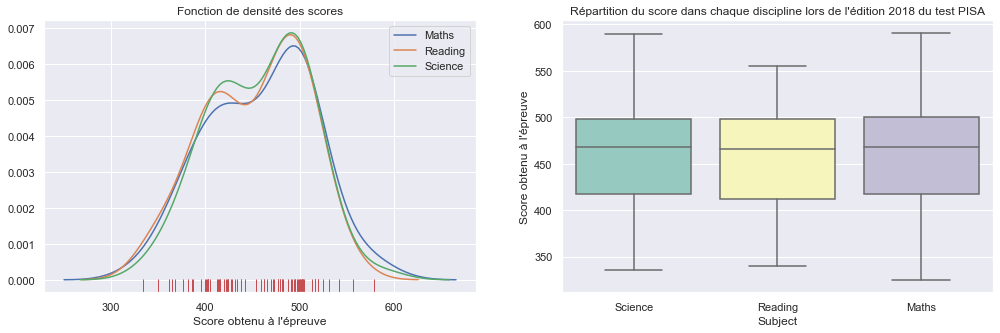

In [26]:
sns.set()
fig, axs = plt.subplots(1, 2, figsize=(17,5))

sns.distplot(Ranking_specific_year["Maths"].dropna(), hist=False, label="Maths", ax = axs[0])
sns.distplot(Ranking_specific_year["Reading"].dropna(), hist=False, label="Reading", ax = axs[0])
sns.distplot(Ranking_specific_year["Science"].dropna(), hist=False, label="Science", ax = axs[0])
sns.distplot(Ranking_specific_year["Mean_score"].dropna(), hist=False, kde=False, rug=True, ax = axs[0])
axs[0].set_title("Fonction de densité des scores")
axs[0].set_xlabel("Score obtenu à l'épreuve")

sns.boxplot(x="Subject", y="Score", data=PISA[PISA["Year"]==Specific_year], palette="Set3", ax = axs[1])
axs[1].set_title("Répartition du score dans chaque discipline lors de l'édition 2018 du test PISA")
axs[1].set_ylabel("Score obtenu à l'épreuve")
plt.show()

On constate que :
* La répartition des scores est assez proche pour les trois compétences testées.
* 50% des pays participants ont un score compris entre environ 420 et 500 pour les trois disciplines.
* Les trois densités s'apparentent à une somme de deux courbes en cloche, l'une qui atteindrait son pic aux alentours de 430, l'autre qui atteindrait son pic aux alentours de 490. Il semble donc, on y reviendra plus loin, que les pays participants peuvent être séparés en deux sous-groupes assez homogènes.
* Les valeurs sont un peu plus faibles et un peu plus concentrées pour l'épreuve de lecture que pour les épreuves de maths et de sciences.

#### 3. Quels sont les pays dont le score moyen a le plus évolué entre 2015 et 2018 ?

In [27]:
Ranking_previous_test = PISA_pivote[PISA_pivote["Year"]==Specific_year - 3][["Country", "Mean_score"]]
Ranking_previous_test.columns = ["Country", "Mean_score_previous_test"]
Ranking_specific_year = Ranking_specific_year.merge(Ranking_previous_test, on="Country")
new_col = Ranking_specific_year.apply(lambda row : (row["Mean_score"]-row["Mean_score_previous_test"]), axis=1)
Ranking_specific_year["Evolution"] = new_col

In [28]:
fig = px.choropleth(Ranking_specific_year, locations="iso3code",
                    color="Evolution", hover_name="Country",
                    color_continuous_scale="Spectral", animation_frame="Year",
                    range_color = [-30,30],
                    title='Évolution du score obtenu en 2018 par rapport à celui obtenu en 2015 (moyenne sur les 3 disciplines)')
fig.show()

L'édition 2018 révèle une tendance préoccupante en Europe particulièrement où la majorité des pays voient leur score diminuer par rapport à l'édition 2015. Remarquons la présence de quelques valeurs extrêmes :
* Du côté des très bonnes surprises, on retrouve comme attendu la **Chine** (+64), mais aussi la **Turquie** (+38), la **Jordanie** (+17).
* Du côté des très mauvaises surprises, on trouve le **Kazakhstan** (-45), l'**Argentine** (-27), la **Géorgie** (-18).

### B. Évolution des résultats par année et par pays

In [29]:
fig = px.choropleth(PISA_pivote, locations="iso3code",
                    color="Mean_score", hover_name="Country",
                    color_continuous_scale="Spectral", animation_frame="Year",
                    range_color = [350,550],
                    title='Score obtenu au test PISA par année et par pays (moyenne sur les 3 disciplines)')

print("Utiliser la barre de temps en bas de la carte pour faire défiler les années.")
fig.show()

Utiliser la barre de temps en bas de la carte pour faire défiler les années.


Rappel : pour la Chine, le test PISA ne couvre en fait que les villes de Beijing, Shanghai, Jiangsu et Zhejiang. On affiche la valeur sur tout le territoire par abus, mais celle-ci est donc à considérer avec précaution.

Quelques cas intéressants révélés par cette carte, en guise d'illustration :
* On a vu ci-dessus que le **Kazakhstan** était le pays dont le score moyen a le plus reculé en 2018 par rapport à 2015. Cette contre-performance est particulièrement surprenante si l'on s'intéresse au chemin parcouru, car elle s'inscrit à contre-courant d'une dynamique très favorable. Depuis 2009, son score ne cessait de croître (passant de 398 en 2009 à 448 en 2015), mais tous les progrès ont vraisemblablement disparu en trois ans (402 en 2018).
* On a vu ci-dessus que la **Turquie** avait gagné 38 points entre 2015 et 2018, obtenant un score moyen de 463. En fait, il ne s'agit pas d'une dynamique de long-terme mais plutôt de la correction d'un choc brutal survenu en 2015. Le pays avait déjà un score moyen de 462 en 2012. Il avait chuté soudainement à 424 en 2015. Le score de 2018 n'est donc qu'un retour à la situation connue en 2012.
* L'**Allemagne** a souvent été citée comme un cas emblématique, car le pays aurait vécu un véritable ["choc PISA"](https://www.lemonde.fr/education/article/2019/12/03/en-allemagne-l-enquete-pisa-a-provoque-un-sursaut-du-systeme-educatif_6021463_1473685.html) en découvrant, dès 2000, que son score moyen était bien inférieur à la moyenne des pays de l'OCDE. Elle aurait alors entrepris d'importantes mesures afin d'améliorer le niveau de ses élèves. En effet : son score moyen est passé de 484 en 2000 à 515 en 2012. Mais depuis 2015, il chute : il repasse à 500 pour l'édition 2018 du test PISA. Le pays a donc perdu la moitié des points qu'il avait réussi à gagner en 12 ans...
* L'Europe de l'Est a connu un phénomène de rattrapage au début des années 2000, qui s'est là aussi interrompu en 2012. Par exemple, la **Pologne** avait un score de 479 en 2000. Il croît constamment jusqu'en 2012 où il atteint 521, mais il décroche ensuite et retombe à 513.
* Les pays scandinaves sont souvent évoqués pour la réussite de leur système scolaire. Pourtant, leurs performances au test PISA sont mitigées. Dans l'absolu, leurs scores sont très élevés, mais leur dynamique n'est pas des plus favorables. Le score moyen de la **Finlande** était très élevé (553) en 2006, mais il chute incessamment depuis (516 en 2018).

### C. Comment va la France ?

In [30]:
PISA_France = PISA[PISA["Country"]=="France"]

#### 1. Évolution de sa performance au fil du temps

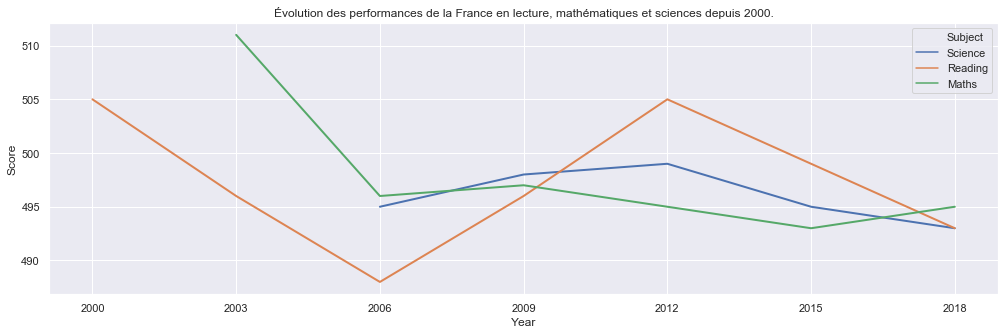

In [31]:
sns.set()
fig, axs = plt.subplots(1, 1, figsize=(17,5))
sns.lineplot(x="Year", y="Score", hue="Subject", data=PISA_France, ax=axs, linewidth=2)
plt.xticks(range(2000,2021,3))
plt.title("Évolution des performances de la France en lecture, mathématiques et sciences depuis 2000.")
plt.show()

On constate, comme l'ont souligné de nombreux journaux, que la France voit ses performances diminuer régulièrement depuis 2012. Plus particulièrement : dans la dernière enquête PISA réalisée en 2018, la France a perdu 6 points en lecture et 2 en sciences, en comparaison avec la précédente étude réalisée en 2015. Seule consolation : elle en regagne 2 en mathématiques.

In [32]:
PISA_France_pivote = PISA_pivote[PISA_pivote["Country"]=="France"]
PISA_France_pivote[PISA_France_pivote["Year"].isin(range(2012,2019))][["Country", "Year", "Mean_score"]]

Country  Year  Mean_score
115  France  2018       493.7
114  France  2015       495.7
113  France  2012       499.7

En moyenne, toutes disciplines confondes, elle a ainsi perdu 4 poids entre 2012 et 2015, puis encore 2 points entre 2015 et 2018.

#### 2. Comparaison avec la performance moyenne des pays de l'OCDE
Cela n'aurait pas de sens de comparer la France avec la performance moyenne de tous les pays participants aux tests PISA car **de nouveaux pays** (souvent, des pays aux performances inférieures à la moyenne) **s'ajoutent à chaque édition**. On choisit donc de comparer la France aux pays membres de l'OCDE, qui constituent un ensemble de pays relativement homogène, qui participent historiquement à ce test, et qui sont souvent pris pour groupe de référence.

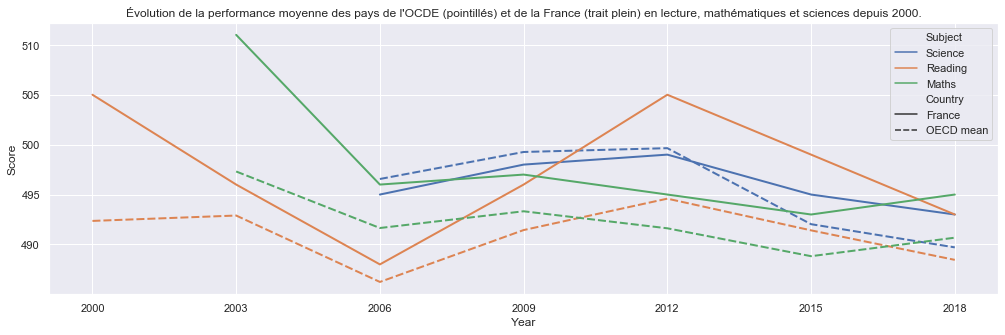

In [33]:
# Calcul des scores moyens pour les pays de l'OCDE
PISA_OECD_aggregated = PISA[PISA["is_OECD"]==1].groupby(['Year', 'Subject', 'is_OECD']).agg("mean")
PISA_OECD_aggregated = PISA_OECD_aggregated.reset_index(drop=False)
PISA_OECD_aggregated["Country"] = "OECD mean"
PISA_France_vs_OECD = pd.concat([PISA_France, PISA_OECD_aggregated], sort = True)

# Affichage du graphique comparant la France avec les pays de l'OCDE
sns.set()
fig, axs = plt.subplots(1, 1, figsize=(17,5))
sns.lineplot(x="Year", y="Score", hue="Subject", style="Country", data=PISA_France_vs_OECD, ax=axs, linewidth=2)
plt.xticks(range(2000,2021,3))
plt.title("Évolution de la performance moyenne des pays de l'OCDE (pointillés) et de la France (trait plein) en lecture, mathématiques et sciences depuis 2000.")
plt.show()

Ce graphique conduit à relativiser, ou du moins à donner un contexte, à la contre-performance française. Certes, la performance de la France ces dernières années n'est pas fameuse. Mais si on la compare, discipline par discipline, **la France est toujours au-dessus de la moyenne des pays de l'OCDE**.
* En lecture et en maths, la France suit une tendance très proche de celle de l'OCDE :
    * Quand la performance des pays de l'OCDE augmente en moyenne dans ces deux disciplines (2006-2012), il en va de même pour la France.
    * Quand la performance des pays de l'OCDE diminue en moyenne dans ces deux disciplines (2012-2018), il en va de même pour la France.
* En sciences, la France parvient à faire mieux que la tendance des pays de l'OCDE et à s'en "libérer" : 
    * En 2006-2012, elle est légèrement au-dessous de la moyenne de l'OCDE en sciences. 
    * Depuis 2015, elle fait mieux que la moyenne : si son niveau moyen dans cette discipline diminue, il diminue en fait bien moins vite que celui des autres pays de l'OCDE.

Ce graphique pousse donc à tirer **des conclusions plus positives que précédemment** : en fait, tout dépend comment on utilise le score PISA.
* Si on le considère en tant que tel, alors oui, indéniablement, **le niveau des élèves français baisse constamment depuis 2012, surtout en lecture**. 
* Si on le considère à la lumière de la performance moyenne des autres pays de l'OCDE, alors on peut se "réjouir" du fait que **la France ne soit pas seule dans cette situation** et qu'elle **demeure ainsi au-dessus de la moyenne**.

Le commentateur, suivant son objectif, ne manquera pas d'insister sur l'un ou l'autre des constats pour "faire parler les chiffres". Sans surprise, le communiqué du Ministère de l'Éducation Nationale, cité en introduction, se concentre plutôt sur le second point.

### D. Évolution de la répartition de la performance au sein de l'OCDE

Le package Plotly nous permet de proposer des boxplots dynamiques, qui facilitent la comparaison de la répartition au fil des ans.

In [34]:
PISA_OECD = PISA[PISA["is_OECD"]==1].copy()
PISA_OECD = PISA_OECD[PISA_OECD["Year"]>=2006]

In [35]:
fig = px.box(PISA_OECD, x="Subject", y="Score", hover_name="Country", animation_frame="Year", points="all",
            title="Évolution de la répartition des scores au sein de l'OCDE, par année et par compétence.")
fig.update_yaxes(range=[400, 600])
print("Utiliser la barre de temps en bas du graphique pour faire défiler les années.")
fig.show()

Utiliser la barre de temps en bas du graphique pour faire défiler les années.


Deux constats principaux surgissent de ces représentations lorsqu'on fait varier l'axe temps. Entre 2012 et 2018 : 
* **La performance baisse dans tous les domaines** : les principaux quantiles diminuent tous.
* **La performance s'homogénéise** :
    * Les "très bons" deviennent progressivement moins bons. Par exemple, en 2012, les trois meilleurs pays de l'OCDE en sciences étaient le Japon (547), l'Estonie (545) et la Finlande (541). Ces trois pays ont vu leur score chuter depuis lors, passant respectivement à 529, 530 et 522. 
    * En revanche, les "moins bons" de l'OCDE tendent à stagner voire à reculer davantage, comme c'est le cas du Mexique et du Chili qui ne parviennent pas à surmonter leurs difficultés en maths.

## III. Approfondissements
Cette partie se concentre sur les tests réalisés après 2006, car toutes les épreuves n'existaient pas encore les années précédentes.

In [36]:
PISA_pivote_post2006 = PISA_pivote[PISA_pivote["Year"]>=2006].copy()

### A. Quelle corrélation entre le score dans une compétence et une autre, pour un pays et une année donnés ?

On est donc en présence, pour chaque pays, et pour chaque édition du test PISA, de trois variables : le score en maths, en lecture, et en sciences. On a pu observer, sur divers exemples, que la majorité des pays obtenaient des scores très similaires dans les trois domaines (un pays "bon" en maths est généralement "bon" en sciences et en lecture). De plus, on a étudié, à plusieurs reprises, le "score moyen" calculé par pays et par année. Cet indicateur est pratique parce qu'il facilite la comparaison, mais il peut néanmoins cacher des disparités. On voudrait donc savoir s'il existe des pays qui performent particulièrement mieux dans un domaine que dans un autre, ce que ne permettrait pas de voir un score moyen.

#### 1. Première approche : corrélation entre les 3 variables PISA

In [37]:
print("Matrice de corrélation entre les scores obtenus dans les trois compétences.")
np.round(PISA_pivote_post2006[["Maths", "Reading", "Science"]].corr(),3)

Matrice de corrélation entre les scores obtenus dans les trois compétences.


Maths  Reading  Science
Maths    1.000    0.949    0.974
Reading  0.949    1.000    0.969
Science  0.974    0.969    1.000

On constate sans surprise que les trois variables sont très fortement corrélées :
* Maths et Reading sont corrélées à 94,9%
* Maths et Science sont corrélées à 97,3%
* Science et Reading sont corrélées à 96,9%

Obtenir un bon ou un mauvais score dans une compétence est donc fortement corrélé au fait d'obtenir un bon ou un mauvais score dans une autre compétence. Ce résultat est confirmé par les graphiques croisés ci-dessous, qui croisent le score dans une matière avec le score dans une autre matière.

Score dans une matière en fonction du score dans une autre matière.


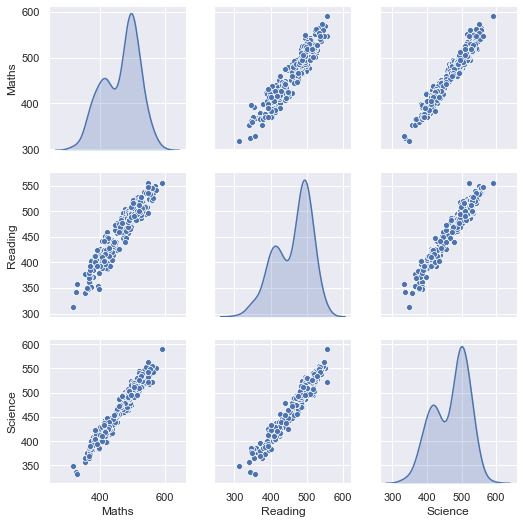

In [38]:
sns.pairplot(PISA_pivote_post2006[["Maths", "Reading", "Science"]].dropna(), diag_kind="kde")
print("Score dans une matière en fonction du score dans une autre matière.")

#### 2. Deuxième approche : calcul des écarts [max-min]
On constate que certains pays s'éloignent quand même légèrement de la bissectrice sur les graphiques ci-dessus. Cela est particulièrement visible sur le graphique qui croise la performance en maths et en lecture, les deux composantes les moins corrélées. On voudrait pouvoir identifier ces pays.
Pour cela, on va étudier l'écart [max(maths, reading, science) - min(maths, reading, science)], pour chaque pays et pour chaque année.

In [39]:
Ecart_max = PISA_pivote_post2006.apply(lambda row : max(row["Maths"],row["Reading"],row["Science"]) 
                                - min(row["Maths"],row["Reading"],row["Science"]), axis=1)
PISA_pivote_post2006["Ecart_max"] = Ecart_max
print("Top 5 des pays ayant le plus gros écart [max-min] en 2018")
PISA_pivote_post2006=PISA_pivote_post2006.sort_values(by=["Year","Ecart_max"], ascending=False)
np.round(PISA_pivote_post2006[["Country", "Ecart_max", "Maths", "Reading", "Science"]], 1).head(5)

Top 5 des pays ayant le plus gros écart [max-min] en 2018


Country  Ecart_max  Maths  Reading  Science
207      Lebanon       40.0  393.0    353.0    384.0
189   Kazakhstan       36.0  423.0    387.0    397.0
65         China       36.0  591.0    555.0    590.0
58         Chile       35.0  417.0    452.0    444.0
253  Netherlands       34.0  519.0    485.0    503.0

On constate donc que, pour la seule année 2018, les pays participants affichent des écarts [max-min] allant jusqu'à 40 points. Par exemple, le **Liban** obtient un score 40 points plus élevé en maths qu'en lecture. À l'inverse, le **Chili** obtient un score 35 points plus élevé en lecture qu'en maths.

In [40]:
fig = px.box(PISA_pivote_post2006, x="Year", y="Ecart_max", hover_name="Country", points="all",
             hover_data=["Maths", "Reading", "Science","is_OECD"],
             title="Répartition de l'écart [max-min] calculé précédemment, par année.")
fig.show()

Exemple de lecture : en 2018, on constate que...
* 25% des pays font preuve d'une grande homogénéité dans leurs compétences avec un écart [max-min] inférieur à 8 points.
* 50% des pays ont un écart [max-min] compris entre 8 et 25 points.
* 25% des pays font preuve d'une forte hétérogénéité dans leurs compétences avec un écart [max-min] supérieur à 25 points.

#### 3. Visualisation synthétique

La visualisation 3D ci-dessous permet de synthétiser cette partie sur l'écart [max-min] en affichant, pour chaque pays : son score en maths, en lecture, en sciences. On peut ainsi isoler les pays qui "dévient" de l'axe x=y=z et repérer facilement les pays qui seraient meilleurs en lecture qu'en mathématiques, par exemple.

* La barre en bas du graphe permet de faire défiler les années.
* Les losanges symbolisent un pays membre de l'OCDE, les ronds symbolisent un pays non membre de l'OCDE.
* Le gradient de couleur permet de repérer les pays ayant le plus fort écart [max-min].

In [41]:
fig = px.scatter_3d(PISA_pivote_post2006, x="Maths", y="Reading", z="Science", color="Ecart_max", 
                    hover_name="Country", hover_data=["Maths", "Reading", "Science", "Mean_score"], 
                    color_continuous_scale="Picnic", animation_frame="Year", range_color = [0,40],
                    title="Visualisation 3D du score en maths, lecture, sciences, par pays et par année.")

fig.show()

#### 4. Que retenir ?
Les considérations ci-dessus incitent donc à la vigilance quand on parle du "classement" PISA : il est pratique de comparer des scores moyens, comme nous l'avons fait, et comme il est courant de le faire par ailleurs. Les moyennes demeurent utiles et pertinentes, parce que les écarts restent généralement modérés : il n'y a pas de pays qui serait premier en mathématiques et dernier en lecture, par exemple... Toutefois, se limiter à des moyennes est une approche incomplète. Par exemple, les Pays-Bas obtiennent un score moyen supérieur de 10 points à celui de la France. On serait alors tentés d'en conclure que ce pays est "meilleur", "mieux classé", ou même que son système scolaire fonctionne mieux. Pourtant, ses résultats en lecture sont inférieurs de 8 points à ceux de la France (485 vs 493). On retiendra donc qu'il est indispensable d'adopter quelques précautions de langage quand on parle de "classement PISA" et que les moyennes ne sont qu'un agrégat qui cache des disparités.

### B. Formation de clusters par méthode de K-means

Dans la partie [II - A - 2. Comment sont réparties les performances en 2018 ?](#2.-Comment-sont-réparties-les-performances-en-2018-?), on a représenté la densité des scores obtenus en maths, en lecture et en sciences en 2018. On a remarqué, en observant ces courbes, qu'elles s'apparentaient "à vue d'oeil", à la somme de deux courbes en cloche, ce qui laisse à penser qu'on pourrait scinder les pays participants en deux groupes relativement homogènes en termes de performance. Au moyen d'un algorithme k-means, on va chercher à classifier les pays participants au test PISA en deux catégories, pour chaque édition du test.

#### 1. Formation des clusters pour chaque année
Les seules variables d'entrée utilisées pour former les clusters sont le score en mathématiques, en lecture et en science. Les différents indicateurs économiques qui seront étudiés plus tard n'entrent pas du tout en compte dans la formation des clusters.

In [42]:
sub_table = PISA_pivote[pd.notnull(PISA_pivote["Maths"]) & pd.notnull(PISA_pivote["Reading"]) 
                                   & pd.notnull(PISA_pivote["Science"])].copy()

model=KMeans(n_clusters=2)
PISA_pivote_clusters = pd.DataFrame()

for Year in sub_table["Year"].unique():
    
    # On calcule les clusters séparément pour chaque année du test PISA.
    sub_table_year = sub_table[sub_table["Year"] == Year].copy()
    model.fit(sub_table_year[["Maths", "Science", "Reading"]])
    sub_table_year["Cluster"] = model.labels_
    
    # Précaution pour s'assurer que les id de clusters soient rangés par niveau de performance moyen croissant.
    Mean_by_cluster = sub_table_year.groupby("Cluster", as_index=False).agg("mean").sort_values(by="Mean_score")
    i=1
    for Cluster in Mean_by_cluster['Cluster']:
        sub_table_year['Cluster'] = sub_table_year['Cluster'].replace(Cluster, 'Cluster '+str(i))
        i+=1
    
    PISA_pivote_clusters = pd.concat([PISA_pivote_clusters, sub_table_year])

#### 2. Visualisation des individus composant chaque cluster, par année

In [43]:
fig = px.scatter_3d(PISA_pivote_clusters, x="Maths", y="Reading", z="Science", color="Cluster", 
                    hover_name="Country", hover_data=["Maths", "Reading", "Science"], animation_frame="Year",
                    title="Performance en maths, lecture et sciences des pays composant les deux clusters, par année.",
                    symbol="is_OECD")

fig.show()

#### 3. Comparaison des deux clusters
Cette sous-partie se concentre sur l'année 2018 en guise d'illustration.

In [44]:
PISA_pivote_2018_clusters = PISA_pivote_clusters[PISA_pivote_clusters["Year"]==2018].copy()

Cluster_1 = PISA_pivote_2018_clusters[PISA_pivote_2018_clusters["Cluster"]=='Cluster 1']
print("Le cluster 1 est composé de", len(Cluster_1["iso3code"]), "pays, dont le score moyen est compris entre", min(Cluster_1["Mean_score"]), "et", max(Cluster_1["Mean_score"]))

Cluster_2 = PISA_pivote_2018_clusters[PISA_pivote_2018_clusters["Cluster"]=='Cluster 2']
print("Le cluster 2 est composé de", len(Cluster_2["iso3code"]), "pays, dont le score moyen est compris entre", min(Cluster_2["Mean_score"]), "et", max(Cluster_2["Mean_score"]))


Le cluster 1 est composé de 34 pays, dont le score moyen est compris entre 334.3 et 442.3
Le cluster 2 est composé de 43 pays, dont le score moyen est compris entre 453.3 et 578.7


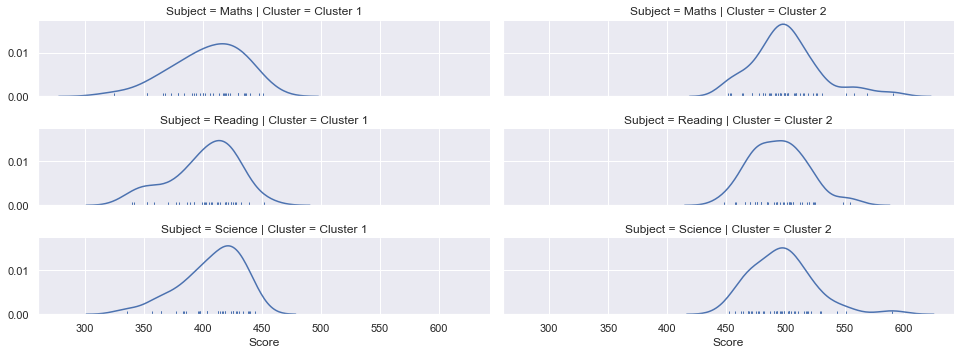

In [45]:
PISA_2018_clusters = PISA_pivote_2018_clusters.melt(id_vars=['Country', 'Year', 'is_OECD', 'iso3code', 'GDP_per_capita', 'life_expect', 'gov_exp', 'pupil_teacher_ratio', 'Cluster', 'Mean_score'], var_name='Subject', value_name='Score')
g = sns.FacetGrid(PISA_2018_clusters, row="Subject", col="Cluster", height=1.7, aspect=4)
g.map(sns.distplot, "Score", hist=False, rug=True);

On a bien réussi à décomposer les participants en deux catégories homogènes, dont les scores ont pour densité une courbe en cloche comme anticipé. Comparons les caractéristiques de ces deux clusters.

In [46]:
print("Comparaison des caractéristiques moyennes entre les deux clusters.")
np.round(PISA_pivote_2018_clusters.groupby(['Cluster', 'Year']).agg('mean'), 1)

Comparaison des caractéristiques moyennes entre les deux clusters.


is_OECD  GDP_per_capita  life_expect  gov_exp  \
Cluster   Year                                                  
Cluster 1 2018      0.1         12324.5         76.0      4.2   
Cluster 2 2018      0.7         39642.5         80.2      4.9   

                pupil_teacher_ratio  Maths  Reading  Science  Mean_score  
Cluster   Year                                                            
Cluster 1 2018                 17.3  404.2    401.0    407.4       404.2  
Cluster 2 2018                 13.6  501.2    494.3    497.3       497.6

* Le cluster 1 est composé des pays ayant un **score moyen supérieur à 450** : ils sont...
    * Majoritairement membres de l'OCDE (72% d'entre eux)
    * Majoritairement riches (PIB par tête de 39k \\$, de l'ordre de celui de la France qui est de 44k \$)
    * Investissent davantage dans l'éducation que la moyenne des participants (4,9% du PIB)
    * Ont une espérance de vie à la naissance plus élevée que la moyenne (80 ans)
    * Ont un ratio élèves par professeur à l'école primaire inférieur à la moyenne (13,6).
* Le cluster 2 est composé des pays ayant un **score moyen inférieur à 450** : ils sont...
    * Majoritairement non membres de l'OCDE (6% d'entre eux)
    * Majoritairement pauvres (PIB par tête de 12k \$, 3 fois plus faible que dans le cluster 1)
    * Investissent moins dans l'éducation que la moyenne des participants (4,2% du PIB)
    * Ont une espérance de vie à la naissance plus faible que la moyenne (76 ans)
    * Ont un ratio élèves par professeur à l'école primaire supérieur à la moyenne (17,3).

#### 4. Que retenir ?
On observe donc l'existence de **deux groupes, tous deux plutôt homogènes** dans leur composition en termes de performance scolaire. Cette dichotomie semble assez intuitive puisqu'elle consiste à séparer :
* Des pays développés, riches, où l'on vit plus longtemps, où les gouvernements investissent davantage dans l'éducation, et où les performances scolaires sont plus élevées.
* Des pays moins développés, plus pauvres, où l'on vit moins longtemps, où les gouvernements investissent moins dans l'éducation, et où les performances scolaires sont moins élevées.

Au passage, rappelons que tous les pays ne participent pas au test PISA : cette démarche est facultative, ce qui entraîne forcément un **biais d'auto-sélection**, et donc notre clusterisation ne permet pas de décrire l'état du monde mais seulement de caractériser un pool de pays bien particulier qui a choisi de participer aux tests PISA. Notons que les pays qui ne participent pas à l'enquête PISA (une centaine, tout de même) sont pour la plupart des pays en [voie de développement](https://fr.wikipedia.org/wiki/Pays_en_d%C3%A9veloppement), où les taux de scolarisation sont faibles. Si ceux-ci devaient être intégrés au test PISA, il serait probablement utile de considérer à minima un troisième cluster dont le score PISA moyen serait probablement plus faible que celle des deux clusters actuels.

Enfin, au vu de ce qui précède, on est tenté de penser que le score PISA serait... 
* Positivement corrélé avec : le fait d'être membre de l'OCDE, le PIB par tête, le fait d'investir dans l'éducation, l'espérance de vie à la naissance.
* Négativement corrélé avec : le nombre d'enfants par classe à l'école primaire.

La partie suivante s'intéresse à l'existence et à la pertinence de ces corrélations.

### C. Étude de corrélation avec différents indicateurs
Au préalable, on décide de : 
* Supprimer la Chine de notre base de données. En effet, comme indiqué précédemment : dans ce pays, les tests PISA n'ont été effectués que dans certaines régions particulièrement riches et très peu représentatives. 
* Supprimer les lignes pour lesquelles des valeurs sont manquantes. Elles sont peu nombreuses et concernent principalement Taiwan et le Montenegro, pays pour lesquels la Banque Mondiale ne fournit pas tous les indicateurs économiques.

In [47]:
PISA_pivote_post2006 = PISA_pivote_post2006[PISA_pivote_post2006["Country"] != "China"].dropna().copy()

L'objectif de cette partie est d'étudier la corrélation entre le score moyen obtenu au score PISA et les indicateurs suivants :
* L'indicatrice d'appartenir ou non à l'OCDE (is_OECD)
* Les dépenses gouvernementales dans l'éducation en % du PIB (gov_exp)
* Le ratio nombre d'élèves / professeur à l'école primaire (pupil_teacher_ratio)
* L'espérance de vie à la naissance (life_expect)
* Le PIB par tête (GDP_per_capita)

#### 1. Un premier aperçu général
Commençons par croiser le score PISA moyen obtenu par pays et par année avec ces différentes variables, une à une.

Score moyen obtenu au test PISA en fonction de différents indicateurs. 
Chaque point représente le score moyen d'un pays pour une année donnée.


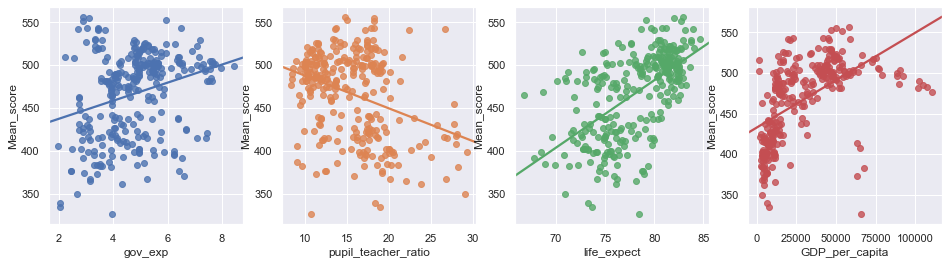

In [48]:
sns.set()
fig, axs = plt.subplots(1, 4, figsize=(16,4))
sns.regplot(x="gov_exp", y="Mean_score", data=PISA_pivote_post2006, ax=axs[0], ci=None)
sns.regplot(x="pupil_teacher_ratio", y="Mean_score", data=PISA_pivote_post2006, ax=axs[1], ci=None)
sns.regplot(x="life_expect", y="Mean_score", data=PISA_pivote_post2006, ax=axs[2], ci=None)
sns.regplot(x="GDP_per_capita", y="Mean_score", data=PISA_pivote_post2006, ax=axs[3], ci=None)
print("Score moyen obtenu au test PISA en fonction de différents indicateurs. \nChaque point représente le score moyen d'un pays pour une année donnée.")
plt.show()

À vue d'oeil, on constate que :
* La corrélation avec les variables gov_exp et pupil_teacher_ratio n'est vraiment pas flagrante.
* La corrélation avec life_expect semble plutôt bien fonctionner (nuage en forme de cône) malgré des points très dispersés.
* La corrélation avec GDP_per_capita semble très efficace mais la forme du nuage de points nous incite à considérer plutôt le logarithme du PIB par tête. Calculons-le et observons le résultat.

#### 2. Régression simple sur log(PIB par tête)

In [49]:
PISA_pivote_post2006['log_GDP_per_capita'] = np.log(PISA_pivote_post2006['GDP_per_capita'])
fig = px.scatter(PISA_pivote_post2006, x="log_GDP_per_capita", y="Mean_score", 
                 hover_data=["Maths", "Reading", "Science", "is_OECD"], hover_name="Country", trendline="ols",
                 title='Score PISA moyen en fonction du log(PIB par tête) ($ 2010), par pays et par année.')
fig.show()

In [50]:
results = px.get_trendline_results(fig)
results.px_fit_results[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     255.4
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           9.81e-42
Time:                        15:19:30   Log-Likelihood:                -1471.9
No. Observations:                 294   AIC:                             2948.
Df Residuals:                     292   BIC:                             2955.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.3908     22.147      5.165      0.000      70.804     157.978
x1            35.6109      2.229     15.980      0.000      31.225      39.997
==============================================================================
Omnibus:                       45.049   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.371
Skew:                          -0.571   Prob(JB):                     3.72e-38
Kurtosis:                       6.573   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interprétation :
* La p-valeur quasi-nulle du coefficient x<sub>1</sub> permet de rejeter l'hypothèse nulle au seuil usuel de 5% et indique que le log(PIB par tête) a un effet statistiquement significatif sur le score PISA moyen.
* Étant donné qu'il s'agit d'un modèle en niveau-log, le coefficient x<sub>1</sub> indique que : toutes choses égales par ailleurs, lorsque le PIB par tête d'un pays augmente de 1%, on estime que son score PISA moyen va augmenter de 36 points en moyenne.

Le passage en logarithme permet donc bien d'obtenir un effet explicatif satisfaisant pour la variable PIB par tête.

#### 3. Régression multiple sur les 5 variables d'intérêts

On souhaite désormais estimer le modèle suivant :
$Mean\_score = const + x_1 * log\_GDP\_per\_capita + x_2 * gov\_exp + x_3 * life\_expect + x_4 * pupil\_teacher\_ratio + x_5 * is\_OECD$

In [51]:
X = PISA_pivote_post2006[['log_GDP_per_capita', 'gov_exp', 'life_expect', 'pupil_teacher_ratio', 'is_OECD']]
X = sm.add_constant(X)
y = PISA_pivote_post2006['Mean_score']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/Users/pierre/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mean_score   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     64.22
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           7.27e-45
Time:                        15:19:30   Log-Likelihood:                -1454.1
No. Observations:                 294   AIC:                             2920.
Df Residuals:                     288   BIC:                             2942.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 113.6410     50.927      2.231      0.026      13.404     213.878
log_GDP_per_capita     19.9852      4.024      4.967      0.000      12.065      27.905
gov_exp                 0.2412      1.699      0.142      0.887      -3.103       3.585
life_expect             1.8157      0.892      2.035      0.043       0.059       3.572
pupil_teacher_ratio    -0.2575      0.515     -0.500      0.618      -1.272       0.757
is_OECD                28.9419      5.384      5.375      0.000      18.345      39.539
==============================================================================
Omnibus:                       16.176   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.988
Skew:                           0.083   Prob(JB):                     4.63e-10
Kurtosis:                       4.866   Cond. No.                     2.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Étude des p-valeurs** :
* Les p-valeurs associées aux variables gov_exp et pupil_teacher_ratio sont énormes et ne permettent pas de rejeter l'hypothèse nulle. Ces variables n'ont donc aucun effet statistiquement significatif sur le score PISA moyen, contrairement à ce qu'on aurait pu intuiter.
* Les p-valeurs associées aux variables log_GDP_per_capita, life_expect et is_OECD sont quasi-nulles ce qui permet de rejeter l'hypothèse nulle à tous les seuils usuels.

**Étude des coefficients significatifs** : toutes choses égales par ailleurs...
* Le coefficient de log_GDP_per_capita indique que, lorsque le PIB par tête augmente d'1%, on prédit que le score PISA moyen va augmenter de 20 points.
* Le coefficient de life_expect indique que, lorsque l'espérance de vie à la naissance augmente d'1 an, on prédit que le score PISA moyen va augmenter de 2 points environ.
* Le coefficient de is_OECD indique que, lorsqu'un pays est membre de l'OCDE, on prédit que son score PISA moyen sera 25 points supérieur à celui d'un pays non-membre de l'OCDE.

**Commentaire général sur la pertinence** de cette régression : malgré son potentiel prédictif intéressant, celle-ci ne permet absolument pas d'identifier un effet causal en raison de différents biais.
* Un biais de sélection : les pays sélectionnés ne sont pas représentatifs de l'ensemble des pays du monde puisque les pays les moins développés ne sont pas représentés.
* Un biais de variable omise : les régresseurs sont probablement corrélés au terme d'erreur. Un exemple, parmi bien d'autres : notre modèle n'inclut pas l'âge jusqu'auquel la scolarisation est obligatoire. Or, on peut penser que cet indicateur serait positivement corrélé au score PISA et aux dépenses du gouvernement dans l'éducation.

### D. Prédiction du score moyen pour les pays n'ayant pas participé au test PISA
En 2018, seuls 78 pays ont participé au test PISA. Ils sont donc une centaine à ne pas y avoir pris part. À partir de notre modèle ci-dessus, et malgré ses imperfections notables, on va essayer de prédire quel aurait été le score des pays qui n'ont pas pris part au test, pour chaque édition. Ré-utilisons les données scrappées dans la partie 1 afin de construire une table contenant les variables explicatives pour tous les pays du monde, y compris ceux qui n'ont pas participé.

In [52]:
world_indicators = table_GDP_capita
world_indicators['log_GDP_per_capita'] = np.log(world_indicators['GDP_per_capita'])
world_indicators = world_indicators.merge(table_life_expect, on=["iso3code", "Year"], how="left")
world_indicators = world_indicators.merge(table_gov_exp, on=["iso3code", "Year"], how="left")
world_indicators = world_indicators.merge(table_pupil_teacher_ratio, on=["iso3code", "Year"], how="left")
world_indicators = world_indicators.merge(table_iso3codes, on=["iso3code"], how="left")
world_indicators["is_OECD"] = world_indicators.apply(lambda row : (row["Country"] in OECD_countries.values)*1, axis = 1)

# On ne conserve que les lignes des années 2006, 2009, ..., 2018, pour lesquelles il n'y a pas d'indicateur manquant
world_indicators = world_indicators[world_indicators["Year"].isin(range(2006,2020,3))].dropna()
world_indicators.head()

iso3code  Year  GDP_per_capita  log_GDP_per_capita  life_expect  gov_exp  \
265      GTM  2018     3159.967477            8.058317    73.810000  2.79538   
266      GNB  2018      622.079825            6.433068    57.673000  2.13249   
267      GNQ  2018    10254.993251            9.235520    58.061000  2.18798   
268      GRC  2018    23558.083966           10.067224    81.387805  3.96396   
269      GRD  2018     9096.329959            9.115626    72.388000  3.17043   

     pupil_teacher_ratio            Country  is_OECD  
265             20.26228          Guatemala        0  
266             51.92515      Guinea-Bissau        0  
267             23.22706  Equatorial Guinea        0  
268              9.38027             Greece        1  
269             16.18269            Grenada        0

#### 1. Résultats prédits, par pays et par année

In [53]:
PISA_predict = world_indicators.copy()

# Si un test PISA a eu lieu cette année-là, on ajoute le score moyen réellement obtenu
PISA_sub_table = PISA_pivote[PISA_pivote["Country"]!="China"][["iso3code", "Year", "Mean_score"]]
PISA_predict = PISA_predict.merge(PISA_sub_table, on=["iso3code", "Year"], how="left")

# On crée une colonne qui prédit le score à partir des 5 indicateurs importés et du modèle ci-dessus.
X_predict = PISA_predict[['log_GDP_per_capita', 'gov_exp', 'life_expect', 'pupil_teacher_ratio', 'is_OECD']]
X_predict = sm.add_constant(X_predict)
PISA_predict["Mean_score_predict"] = results.predict(X_predict)
PISA_predict.head()

iso3code  Year  GDP_per_capita  log_GDP_per_capita  life_expect  gov_exp  \
0      GTM  2018     3159.967477            8.058317    73.810000  2.79538   
1      GNB  2018      622.079825            6.433068    57.673000  2.13249   
2      GNQ  2018    10254.993251            9.235520    58.061000  2.18798   
3      GRC  2018    23558.083966           10.067224    81.387805  3.96396   
4      GRD  2018     9096.329959            9.115626    72.388000  3.17043   

   pupil_teacher_ratio            Country  is_OECD  Mean_score  \
0             20.26228          Guatemala        0         NaN   
1             51.92515      Guinea-Bissau        0         NaN   
2             23.22706  Equatorial Guinea        0         NaN   
3              9.38027             Greece        1       453.3   
4             16.18269            Grenada        0         NaN   

   Mean_score_predict  
0          404.159038  
1          334.064981  
2          398.180610  
3          490.092293  
4          423.848677

In [54]:
fig = px.choropleth(PISA_predict, locations="iso3code",
                    color="Mean_score_predict", hover_name="Country", hover_data=["Mean_score"],
                    color_continuous_scale="Spectral", animation_frame="Year",
                    range_color = [350,550],
                    title='Résultats prédits par pays et par année à l\'aide du modèle ci-dessus')
fig.show()

#### 2. Mesure de l'erreur de prédiction

In [55]:
# On calcule l'erreur de prédiction qui est égale à la valeur prédite moins la vraie valeur
PISA_predict["Prediction_error"] = PISA_predict["Mean_score_predict"] - PISA_predict["Mean_score"]
PISA_predict["Prediction_error"].describe()

count    296.000000
mean       0.110483
std       33.991564
min     -124.232284
25%      -18.653395
50%        3.071772
75%       20.968264
max      149.671062
Name: Prediction_error, dtype: float64

On constate que les erreurs de prédiction sont quasi-nulles en moyenne (par construction) mais très dispersées. Pour certains pays et certaines années, l'erreur est de l'ordre de 150 points, ce qui est énorme. Le graphique ci-dessous affiche pour chaque pays, pour chaque année, le score réellement obtenu en fonction du score prédit. Le gradient de couleur quantifie l'erreur de prédiction.

In [56]:
fig = px.scatter(PISA_predict, x="Mean_score", y="Mean_score_predict", hover_name="Country", 
                 hover_data=["Year", "GDP_per_capita", "life_expect", "gov_exp", "pupil_teacher_ratio"], 
                 color="Prediction_error", animation_frame="Year")
bissectrice = np.linspace(300,600)
fig.add_trace(go.Scatter(x=bissectrice, y=bissectrice, mode='lines', name='lines'))
fig.show()

* Les pays en dessous de la bissectrice obtiennent un score moins bon que celui que l'on aurait prédit.
* Les pays au dessus de la bissectrice obtiennent un score meilleur que celui que l'on aurait prédit.

Certains cas s'expliquent assez bien avec l'intuition. Par exemple, en 2018, le Qatar a un score bien plus faible que celui anticipé (quasiment 70 pts d'erreur). Notre prédiction est totalement faussée par un PIB / tête très élevé (63k €) qui ne rend pas compte des inégalités socio-économiques dans ce pays, par exemple.

#### 3. Que retenir ?
Notre modèle est donc très imprécis et les résultats obtenus sont donc à considérer avec vigilance. On pouvait s'y attendre vu le R<sup>2</sup> obtenu ci-dessus (51%). Une solution simple consisterait à augmenter le nombre de variables utilisé, tout en se laissant guider par l'intuition pour leur choix, en observant notamment les pays pour lesquels l'écart est trop faible et en essayant de trouver des indicateurs qui pourraient expliquer ces écarts (ex : mesure des inégalités, etc.). La difficulté toutefois, à laquelle nous avons dû faire face, consiste à trouver des indicateurs faciles d'accès et qui soient disponibles pour tous les pays.

## Conclusion générale
À l'aide de **données scrappées** sur divers sites (Wikipedia, Banque Mondiale, CIA...), nous avons pu analyser les résultats de l'enquête PISA depuis sa création en 2000, en observant l'**évolution de leur répartition au fil du temps**, et en effectuant différents focus sur le cas de la **France** et de l'**OCDE**. Pour revenir sur le cas de la France, on a vu qu'il était possible de **"faire parler"** les chiffres de diverses manières : dans l'absolu, les performances baissent, mais en relatif cette tendance est conforme à celle de l'OCDE. Néanmoins, la question se pose de savoir s'il est toujours pertinent de se comparer aux pays de l'OCDE, un groupe dont la cohérence est discutable, qui comprend des pays comme le Chili ou le Mexique, dont la situation économique est très différente de celle de la France, et qui exclut en même temps des pays riches, dont la situation économique est plus proche de celle de la France, comme Singapour ou la Corée du Sud.

Dans la troisième partie, on a constaté que certains pays affichaient des performances très différentes en mathématiques / lecture / sciences et qu'il était donc utile de **ne pas se limiter à la simple comparaison de scores moyens**. On a ensuite pu observer qu'il était possible et assez naturel de diviser les pays participants en **deux clusters à la performance homogène**. On a remarqué que les pays composant le cluster le plus performant avaient des points communs : ils sont en moyenne beaucoup plus riches, ont une espérance de vie supérieure à la moyenne, ils investissent plus dans l'éducation, ils ont un ratio élèves / professeur à l'école primaire inférieur à la moyenne, et ils sont majoritairement membres de l'OCDE. Partant de ce résultat, on a souhaité approfondir la corrélation avec ces indicateurs en proposant un modèle fondé sur une **régression multivariée**. Enfin, à l'aide de ce modèle, on a proposé une **prédiction du score PISA** de tous les pays du monde, y compris tous ceux qui n'y ont jamais participé, par année. On a néanmoins été contraints d'observer que notre modèle était très imprécis, ce qui nous a poussé à émettre différentes critiques à son sujet, et à faire plusieurs suggestions permettant de l'améliorer.